# Analítica de datos
# Examen parcial 1
# 2020-01
# <font color='red'> Santiago del Campo, A00137608 </font>

El dataset que deben analizar contiene los registros del histórico de las personas a las que se les ha otorgado un crédito financiero, indicando quienes pudieron pagarlo sin problemas y quienes no.

La idea es poder predecir, utilizando modelos de aprendizaje supervisado (KNN y Naïve Bayes) y las variables independientes disponibles qué aspirantes a un crédito tienen mas o menos riesgo de pagar.

Las variables de la hoja de datos son las siguientes:
- ID: El ID único del cliente en el banco. Variable numérica positiva. 
- PudoPagar: Indica si el cliente ha podido pagar el crédito sin problemas (1) o no (0). Variable categórica binaria.
- Estudiante: Indica si el cliente es estudiante (Si) o no lo es (No). Variable categórica binaria.
- Deuda: Indica la cantidad de dinero que aún adeuda el cliente correspondiente a préstamos. Valores numéricos positivos o en cero.
- Cuenta: Indica el dinero que tiene en la cuenta del banco. Valores numéricos. Estas cuentas no permiten tener saldo en rojo.

## Entendimiento de los datos, limpieza

El archivo "creditos_examen.csv" contiene el dataset que tienen que analizar.
Se recomienda abrirlo primero en un lector de archivos planos para entender preliminarmente su formato y así poderlo cargar adecuadamente con Python.

Teniendo en cuenta el tipo de problema en cuestión (clasificación o regresión), realice un análisis exploratorio de los datos estableciendo el baseline, verificando la calidad de los datos (tipos de las variables, valores inválidos, excepciones, valores faltantes, etc.), utilizando gráficos para poder entender las distribuciones de los datos e identificar posibles problemas.

#### Puntos a desarrollar

- <font color='red'>1. Limpieza de datos: Exploren los datos e identifiquen problemas e inconsistencias del dataset teniendo en cuenta el diccionario de datos y del contexto. Arreglen los problemas identificados (solo después de identificarlos todos), argumentando sus decisiones. (2.0)</font>
- <font color='red'>2. Obtengan el modelo de referencia (Baseline), interprételo y calcule su accuracy. (0.3)</font>

## Modelamiento con K-NN y Naïve Bayes

#### Puntos a desarrollar:

<font color='red'>Entrene modelos de clasificación siguiendo el siguiente protocolo:</font>
- <font color='red'>3. Haga un holdout estratificado 70% training - 30% test sobre el dataset solo incluyendo las variables numéricas. No olvide normalizar los datos correctamente (0.3)</font>
- <font color='red'>4. Sobre el training set siga un protocolo de 5 fold cross validation para buscar los mejores valores de los parámetros de un modelo K-NN, teniendo en cuenta el Kappa. Evaluar un modelo global, otro para estudiantes y otro para no estudiantes. Concluir (0.9)</font>
- <font color='red'>5. Sobre el training set siga un protocolo de 5 fold cross validation para buscar los mejores valores de los parámetros de un modelo NaïveBayes, tenga en cuenta utilizar las distribuciones adecuadas a los tipos de variables predictivas. Repetir el proceso de los tres modelos. (0.9) Si quisieramos incluir el efecto de la variable Estudiante en el modelo entrenado con las variables numéricas sin utilizar sklearn, que tenemos que hacer (0.2)</font>
- <font color='red'>6. Sobre el test set compare los dos modelos (K-NN y NB) y escoja el mejor según el Kappa (0.4)</font>

# Desarrollo de los puntos

In [1]:
import numpy as np #operaciones matriciales y con vectores
import pandas as pd #tratamiento de datos
import math
import matplotlib.pyplot as plt #gráficos
import seaborn as sns
from sklearn import datasets
from sklearn import neighbors, metrics
from sklearn.model_selection import train_test_split #metodo de particionamiento de datasets para evaluación
from sklearn.model_selection import cross_val_score, cross_validate #método para evaluar varios particionamientos de C-V
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedKFold, LeaveOneOut #Iteradores de C-V
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer #herramienta para convertir textos en palabras atributos
from sklearn.naive_bayes import GaussianNB




In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_rows', 20)
data = pd.read_csv('creditos_examen.csv', sep=";")
data.head()

,ID,PudoPagar,Estudiante,Deuda,Cuenta
0,1,0,No,4436163,3647632
1,2,0,Si,1210613,4085902
2,3,0,No,3176714,5367746
3,4,0,No,3570449,2646253
4,5,0,No,3846350,3928279


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10002 entries, 0 to 10001
Data columns (total 5 columns):
ID            10002 non-null int64
PudoPagar     10002 non-null int64
Estudiante    9998 non-null object
Deuda         10002 non-null int64
Cuenta        10002 non-null int64
dtypes: int64(4), object(1)
memory usage: 390.8+ KB


...

...

...

# 1. Limpieza de datos

## Identificación de problemas de datos.


In [5]:
data[data.duplicated()]

,ID,PudoPagar,Estudiante,Deuda,Cuenta
1423,1424,0,No,3640304,7574816
8143,8142,0,Si,2428223,1136586


# 1)Existen valores duplicados 

In [6]:
data.count()

ID            10002
PudoPagar     10002
Estudiante     9998
Deuda         10002
Cuenta        10002
dtype: int64

# 2) faltan valores en estudiante

In [7]:
data.describe(include="all")

,ID,PudoPagar,Estudiante,Deuda,Cuenta
count,10002.000000,10002.000000,9998,1.000200e+04,1.000200e+04
unique,NaN,NaN,4,NaN,NaN
top,NaN,NaN,No,NaN,NaN
freq,NaN,NaN,7050,NaN,NaN
mean,5000.379324,0.033293,NaN,3.036624e+06,1.545269e+07
std,2887.127481,0.179410,NaN,7.028235e+07,1.019546e+09
min,-3.000000,0.000000,NaN,-4.288864e+09,-2.247063e+07
25%,2500.250000,0.000000,NaN,1.823657e+06,2.408188e+06
50%,5000.500000,0.000000,NaN,3.209805e+06,4.118185e+06
75%,7500.750000,0.000000,NaN,4.281461e+06,5.833152e+06


In [8]:
data.isnull().values.any()

True

## 3) Existen valores nulos entre los datos

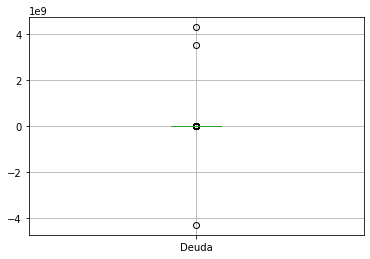

In [9]:
data.boxplot(column=['Deuda'])

## 4) En este BoxPlot podemos identificar que ay una gran cantidad de datos atipicos

In [10]:
data['Deuda'].min()

-4288864105

##  5) Podemos ademas identificar que exiten valores negativos de la deuda, tener una deuda negativa no tiene sentido.

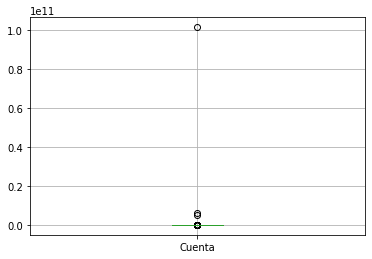

In [11]:
data.boxplot(column=['Cuenta'])

## 6) En este BoxPlot podemos identificar que hay una gran cantidad de datos atipicos

In [12]:
data['Cuenta'].min()

-22470634

## 7) En la cuenta tener valores negativos no tiene sentido 

In [13]:
data["Estudiante"].unique()

array(['No', 'Si', nan, '1', '0'], dtype=object)

## 8) en esta columna deberian existir solo dos valores "si" o "no" y hay unos datos de mas "nan", "1" y "0"


In [14]:
data['ID'].min()

-3

## 9) Los valores de ID deberian ir incrementando desde 0 en adelante, los valores negativos en esta columna no tienen sentido

In [15]:
pd.set_option('display.max_rows', 6)
data["ID"].value_counts()

500     3
1424    2
8142    2
       ..
4759    1
6806    1
2049    1
Name: ID, Length: 9998, dtype: int64

In [16]:
pd.set_option('display.max_rows', 20)

## 10)Existen valores de ID repetidos

...

...

Resumen de los problemas encontrados:
- Se encontro que \[bla bla bla\]. Para solucionar este problema se decidió que \[bla bla bla\], ya que considero que \[bla bla bla\]
- Se encontro que \[bla bla bla\]. Para solucionar este problema se decidió que \[bla bla bla\], ya que considero que \[bla bla bla\]
- Se encontro que \[bla bla bla\]. Para solucionar este problema se decidió que \[bla bla bla\], ya que considero que \[bla bla bla\]
- Se encontro que \[bla bla bla\]. Para solucionar este problema se decidió que \[bla bla bla\], ya que considero que \[bla bla bla\]

# Corrección de problemas de datos.

In [17]:
data.drop_duplicates(keep=False,inplace=True)

In [18]:
data[data.duplicated()]

,ID,PudoPagar,Estudiante,Deuda,Cuenta


In [19]:
pd.set_option('display.max_rows', 20)
data = pd.read_csv('creditos_examen.csv', sep=";")



# eliminamos valores nulos

In [20]:
data=data.dropna()

In [21]:
data.isnull().any()

ID            False
PudoPagar     False
Estudiante    False
Deuda         False
Cuenta        False
dtype: bool

# Ya no hay valores nulos 

# Un valor negativo en la deuda implica un saldo a favro en la cuenta bancaria

In [22]:
promedio=0
for ix in range(0, data['Deuda'].count()):
    sumatoria=0
    index=0
    deuda = data.iloc[ix,3]
    if deuda>0:     
        sumatoria=sumatoria+deuda
        index=index+1
        
promedio=sumatoria/index
        
       

In [23]:
for ix in range(0, data['Deuda'].count()):
    deuda = data.iloc[ix,3]
    if deuda<0:
        data.iloc[ix,3] =promedio        

In [24]:
promedio

1686295.0

In [25]:
data['Deuda'].min()

77197.0

In [26]:
data.head()

,ID,PudoPagar,Estudiante,Deuda,Cuenta
0,1,0,No,4436163.0,3647632
1,2,0,Si,1210613.0,4085902
2,3,0,No,3176714.0,5367746
3,4,0,No,3570449.0,2646253
4,5,0,No,3846350.0,3928279


# Los valores negativos ya no existen en la columna de deuda 

# Los valores negativos en la ceunta de ahorros iimplican un saldo en deuda

In [27]:
promedio=0
for ix in range(0, data['Deuda'].count()):
    sumatoria=0
    index=0
    deuda = data.iloc[ix,4]
    if deuda>0:     
        sumatoria=sumatoria+deuda
        index=index+1
        
promedio=sumatoria/index

In [28]:
for ix in range(0, data['Deuda'].count()):
    deuda = data.iloc[ix,4]
    if deuda<0:
        data.iloc[ix,4] =promedio   

In [29]:
promedio

1004611.0

In [30]:
data['Deuda'].min()

77197.0

#  Los valores negativos ya no existen en la columna ceunta

# Eliminaremos los valores otliners de entre lso datos de deuda

In [31]:

constrains=data['Deuda'].between(data['Deuda'].quantile(.05), data['Deuda'].quantile(.95))
nuevo=data.drop(data.index[~constrains], inplace=True)

data.update(nuevo)

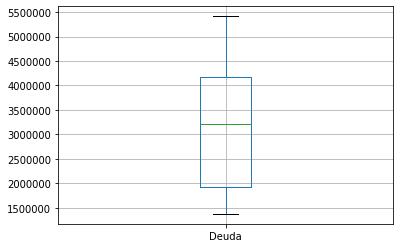

In [32]:
data.boxplot(column=['Deuda'])


In [33]:
data.describe(include="all")

,ID,PudoPagar,Estudiante,Deuda,Cuenta
count,8998.000000,8998.000000,8998,8.998000e+03,8.998000e+03
unique,NaN,NaN,4,NaN,NaN
top,NaN,NaN,No,NaN,NaN
freq,NaN,NaN,6521,NaN,NaN
mean,4980.556235,0.033230,NaN,3.150638e+06,1.669169e+07
std,2884.161490,0.179246,NaN,1.191925e+06,1.074922e+09
min,-3.000000,0.000000,NaN,1.373519e+06,0.000000e+00
25%,2435.250000,0.000000,NaN,1.915344e+06,2.382866e+06
50%,4962.500000,0.000000,NaN,3.209805e+06,4.087738e+06
75%,7482.750000,0.000000,NaN,4.179248e+06,5.812926e+06


# ya no hya outliners en deuda

# solucionamos los valores outliners en Cuenta

In [34]:

constrains=data['Cuenta'].between(data['Cuenta'].quantile(.05), data['Cuenta'].quantile(.95))
nuevo=data.drop(data.index[~constrains], inplace=True)

data.update(nuevo)

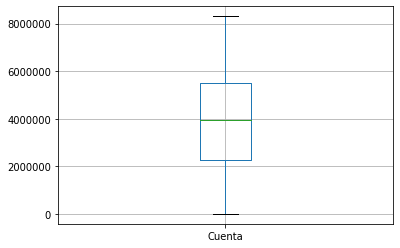

In [35]:
data.boxplot(column=['Cuenta'])

In [36]:
data.describe(include="all")

,ID,PudoPagar,Estudiante,Deuda,Cuenta
count,8548.000000,8548.000000,8548,8.548000e+03,8.548000e+03
unique,NaN,NaN,4,NaN,NaN
top,NaN,NaN,No,NaN,NaN
freq,NaN,NaN,6296,NaN,NaN
mean,4976.619326,0.013687,NaN,3.169669e+06,3.882028e+06
std,2881.601717,0.116197,NaN,1.188534e+06,2.147594e+06
min,-3.000000,0.000000,NaN,1.373705e+06,0.000000e+00
25%,2438.750000,0.000000,NaN,1.933430e+06,2.275714e+06
50%,4961.500000,0.000000,NaN,3.256596e+06,3.935076e+06
75%,7471.250000,0.000000,NaN,4.192198e+06,5.507202e+06


# ya no hay outliners en columna

# Eliminamos los errores en ID

In [37]:
data.isnull().any()

ID            False
PudoPagar     False
Estudiante    False
Deuda         False
Cuenta        False
dtype: bool

In [38]:
data=data.reset_index(drop=True)

data.update(data)
N = data["ID"].count()
data=data.drop(['ID'], axis=1)

nuevo = pd.DataFrame({ 'ID' : range(1, N + 1 ,1)})
display(nuevo)


,ID
0,1
1,2
2,3
3,4
4,5
5,6
6,7
7,8
8,9
9,10


In [39]:
display(data)
data=pd.concat([nuevo,data ], axis=1)

,PudoPagar,Estudiante,Deuda,Cuenta
0,0,No,4436163.0,3647632.0
1,0,No,3176714.0,5367746.0
2,0,No,3570449.0,2646253.0
3,0,No,3846350.0,3928279.0
4,0,No,2490523.0,4127567.0
5,0,Si,1760045.0,4043338.0
6,0,No,3746853.0,5805289.0
7,0,No,2927527.0,0.0
8,0,Si,2187107.0,0.0
9,0,No,2825170.0,1185226.0


In [40]:
display(data)

,ID,PudoPagar,Estudiante,Deuda,Cuenta
0,1,0,No,4436163.0,3647632.0
1,2,0,No,3176714.0,5367746.0
2,3,0,No,3570449.0,2646253.0
3,4,0,No,3846350.0,3928279.0
4,5,0,No,2490523.0,4127567.0
5,6,0,Si,1760045.0,4043338.0
6,7,0,No,3746853.0,5805289.0
7,8,0,No,2927527.0,0.0
8,9,0,Si,2187107.0,0.0
9,10,0,No,2825170.0,1185226.0


In [41]:
data["ID"].min()

1

# Ya no hay valores negativos

In [42]:
pd.set_option('display.max_rows', 6)
data["ID"].value_counts()

2047    1
7489    1
3363    1
       ..
2692    1
645     1
2049    1
Name: ID, Length: 8548, dtype: int64

In [43]:
pd.set_option('display.max_rows', 20)

# ya no hay valores repetidos

# cambiamo los valores que sean "1" o "0" por  "Si" o "No" respectivamente en la columna de Estudiante

In [44]:
def transformar(n):
  if n=="Si" or n=="1" :
    return 1
  if n=="No" or n=="0":
    return 0
  return n

In [45]:
data['Estudiante'] = data.applymap(transformar)['Estudiante']
data.head()

,ID,PudoPagar,Estudiante,Deuda,Cuenta
0,1,0,0,4436163.0,3647632.0
1,2,0,0,3176714.0,5367746.0
2,3,0,0,3570449.0,2646253.0
3,4,0,0,3846350.0,3928279.0
4,5,0,0,2490523.0,4127567.0


In [46]:
data["Estudiante"].unique()

array([0, 1])

## ahora solo existen los valores "Si" y "No" en la columna de estudiante

...

...

...

Tenemos que el dataset después de limpieza cuenta con  8548 registros.

In [47]:
data.count()

ID            8548
PudoPagar     8548
Estudiante    8548
Deuda         8548
Cuenta        8548
dtype: int64

In [48]:
data.head()

,ID,PudoPagar,Estudiante,Deuda,Cuenta
0,1,0,0,4436163.0,3647632.0
1,2,0,0,3176714.0,5367746.0
2,3,0,0,3570449.0,2646253.0
3,4,0,0,3846350.0,3928279.0
4,5,0,0,2490523.0,4127567.0


# 2. Modelo de referencia (Baseline)

98.63125877398222

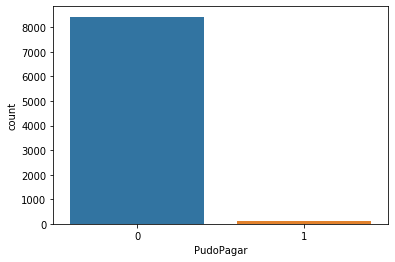

In [49]:
### Baseline
ax = sns.countplot(x="PudoPagar", data=data)
data.PudoPagar[data.PudoPagar==0].aggregate('count') / data.shape[0] * 100

In [50]:
print(data.PudoPagar[data.PudoPagar==0].aggregate('count') / data.shape[0] * 100)

98.63125877398222


# El siguiente cliente no podra pagar su deuda, accuracy del baseLine 98.1%

Lo anterior quiere decir se espera con una probalididad del 0.985 que el siguinte cliente que este en el banco no pueda pagar su deuda

...

...

...

# 3. Holdout sobre el dataset

In [51]:
data.head()

,ID,PudoPagar,Estudiante,Deuda,Cuenta
0,1,0,0,4436163.0,3647632.0
1,2,0,0,3176714.0,5367746.0
2,3,0,0,3570449.0,2646253.0
3,4,0,0,3846350.0,3928279.0
4,5,0,0,2490523.0,4127567.0


In [52]:
x=data[["Cuenta","Deuda"]].values
y=data[["PudoPagar"]].values

In [53]:
print(type(x))
print(type(y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [54]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=7896, stratify=y)

...

...

...

# 4. KNN

In [55]:
data.head()

,ID,PudoPagar,Estudiante,Deuda,Cuenta
0,1,0,0,4436163.0,3647632.0
1,2,0,0,3176714.0,5367746.0
2,3,0,0,3570449.0,2646253.0
3,4,0,0,3846350.0,3928279.0
4,5,0,0,2490523.0,4127567.0


# Global

In [56]:
x=data[["Cuenta","Deuda"]]
y=data["PudoPagar"]

In [57]:
x[0:5]

,Cuenta,Deuda
0,3647632.0,4436163.0
1,5367746.0,3176714.0
2,2646253.0,3570449.0
3,3928279.0,3846350.0
4,4127567.0,2490523.0


In [58]:
y[0:5]

0    0
1    0
2    0
3    0
4    0
Name: PudoPagar, dtype: int64

In [59]:
x["Deuda"]= x["Deuda"] / np.linalg.norm(x["Deuda"])
x["Cuenta"]= x["Cuenta"] / np.linalg.norm(x["Cuenta"])


In [60]:
x[0:5]

,Cuenta,Deuda
0,0.008893,0.014174
1,0.013087,0.010150
2,0.006452,0.011408
3,0.009577,0.012290
4,0.010063,0.007958


In [61]:
y[0:5]

0    0
1    0
2    0
3    0
4    0
Name: PudoPagar, dtype: int64

In [62]:
k=7
knn = neighbors.KNeighborsClassifier(n_neighbors=k)
knn.fit(x, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

In [63]:
y_pred = knn.predict(x)
print("Clases reales   : ", y)
print("Clases predichas: ", y_pred)

Clases reales   :  0       0
1       0
2       0
3       0
4       0
5       0
6       0
7       0
8       0
9       0
       ..
8538    0
8539    0
8540    0
8541    0
8542    0
8543    0
8544    0
8545    0
8546    0
8547    0
Name: PudoPagar, Length: 8548, dtype: int64
Clases predichas:  [0 0 0 ... 0 0 0]


In [64]:
k_vec= np.arange(1,31,2)
k_vec

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29])

In [65]:
kappa_train_vec=[]
kappa_test_vec=[]
k_vec= np.arange(1,31,2)
for k in k_vec:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_train)
    kappa_train_vec.append(metrics.cohen_kappa_score(y_train, y_pred))
    y_pred = knn.predict(X_test)
    kappa_test_vec.append(metrics.cohen_kappa_score(y_test, y_pred))
print(kappa_train_vec)
print(kappa_test_vec)
print(k_vec)

[1.0, 0.08304860128197045, 0.06857994636901088, 0.023172004045842298, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.03762238840490317, -0.0034229828850855792, -0.000758643112604318, -0.000758643112604318, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[ 1  3  5  7  9 11 13 15 17 19 21 23 25 27 29]


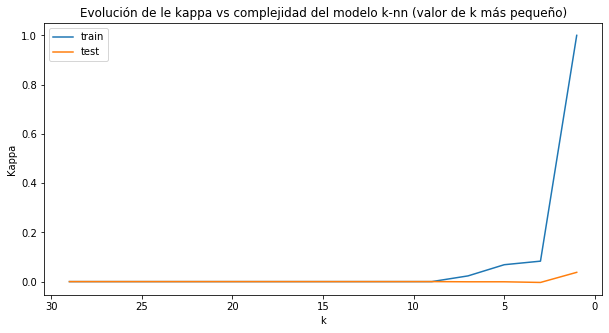

In [66]:
plt.figure(figsize=(10,5))
ax = plt.gca() # get current axis
plt.plot(k_vec, kappa_train_vec)
plt.plot(k_vec, kappa_test_vec)
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('k')
plt.ylabel('Kappa')
plt.title('Evolución de le kappa vs complejidad del modelo k-nn (valor de k más pequeño)')
plt.legend(['train', 'test'])

In [67]:
knn = neighbors.KNeighborsClassifier(n_neighbors=5)
Kappa=metrics.make_scorer(metrics.cohen_kappa_score)
exactitudes = cross_val_score(knn, x, y, cv=5, scoring=Kappa)
exactitudes

array([-0.00312683,  0.        , -0.00215795, -0.00215795,  0.        ])

In [68]:
knn = neighbors.KNeighborsClassifier(n_neighbors=1)
kf = KFold(n_splits=5, shuffle=True)
Kp=[]
for indices_train, indices_test in kf.split(x):
   #print("%s %s" % (indices_train, indices_test))
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    Kp.append(metrics.cohen_kappa_score(y_test, y_pred))  
Kp

[0.03762238840490317,
 0.03762238840490317,
 0.03762238840490317,
 0.03762238840490317,
 0.03762238840490317]

In [69]:
cm= metrics.confusion_matrix(y_test, y_pred)
cm

array([[2490,   40],
       [  33,    2]])

# Estudiantes

In [70]:
data.head()

,ID,PudoPagar,Estudiante,Deuda,Cuenta
0,1,0,0,4436163.0,3647632.0
1,2,0,0,3176714.0,5367746.0
2,3,0,0,3570449.0,2646253.0
3,4,0,0,3846350.0,3928279.0
4,5,0,0,2490523.0,4127567.0


In [71]:
data_est=data.loc[data['Estudiante'] == 1]
data_est=data_est.reset_index(drop=True)
data_est.count()


ID            2249
PudoPagar     2249
Estudiante    2249
Deuda         2249
Cuenta        2249
dtype: int64

In [72]:
x=data_est[["Cuenta","Deuda"]]
y=data_est["PudoPagar"]


In [73]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=7896, stratify=y)

In [74]:
y[0:5]

0    0
1    0
2    0
3    0
4    0
Name: PudoPagar, dtype: int64

In [75]:
x["Deuda"]= x["Deuda"] / np.linalg.norm(x["Deuda"])
x["Cuenta"]= x["Cuenta"] / np.linalg.norm(x["Cuenta"])



In [76]:
x[0:5]

,Cuenta,Deuda
0,0.017389,0.019125
1,0.000000,0.023765
2,0.011344,0.019164
3,0.024074,0.017990
4,0.009652,0.017168


In [77]:
k=7
knn = neighbors.KNeighborsClassifier(n_neighbors=k)
knn.fit(x, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

In [78]:
y_pred = knn.predict(x)
print("Clases reales   : ", y)
print("Clases predichas: ", y_pred)

Clases reales   :  0       0
1       0
2       0
3       0
4       0
5       0
6       0
7       0
8       0
9       0
       ..
2239    0
2240    0
2241    0
2242    0
2243    0
2244    0
2245    0
2246    0
2247    0
2248    0
Name: PudoPagar, Length: 2249, dtype: int64
Clases predichas:  [0 0 0 ... 0 0 0]


In [79]:
k_vec= np.arange(1,31,2)
k_vec

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29])

In [80]:
kappa_train_vec=[]
kappa_test_vec=[]
k_vec= np.arange(1,31,2)
for k in k_vec:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_train)
    kappa_train_vec.append(metrics.cohen_kappa_score(y_train, y_pred))
    y_pred = knn.predict(X_test)
    kappa_test_vec.append(metrics.cohen_kappa_score(y_test, y_pred))
print(kappa_train_vec)
print(kappa_test_vec)
print(k_vec)

[1.0, 0.17116567817748474, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[-0.01180438448566612, -0.004872107186358221, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[ 1  3  5  7  9 11 13 15 17 19 21 23 25 27 29]


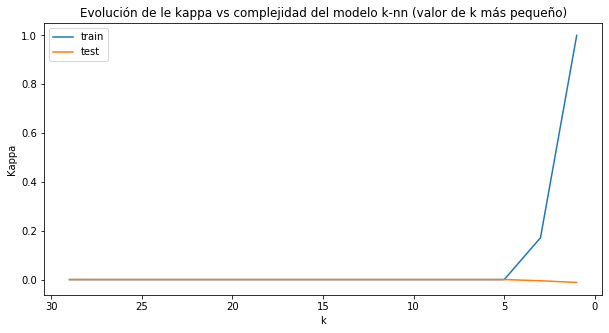

In [81]:
plt.figure(figsize=(10,5))
ax = plt.gca() # get current axis
plt.plot(k_vec, kappa_train_vec)
plt.plot(k_vec, kappa_test_vec)
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('k')
plt.ylabel('Kappa')
plt.title('Evolución de le kappa vs complejidad del modelo k-nn (valor de k más pequeño)')
plt.legend(['train', 'test'])

In [82]:
knn = neighbors.KNeighborsClassifier(n_neighbors=5)
Kappa=metrics.make_scorer(metrics.cohen_kappa_score)
exactitudes = cross_val_score(knn, x, y, cv=5, scoring=Kappa)
exactitudes

array([-0.00382409,  0.        ,  0.        , -0.00382409,  0.        ])

In [83]:
knn = neighbors.KNeighborsClassifier(n_neighbors=1)
kf = KFold(n_splits=5, shuffle=True)
Kp=[]
for indices_train, indices_test in kf.split(x):
   #print("%s %s" % (indices_train, indices_test))
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    Kp.append(metrics.cohen_kappa_score(y_test, y_pred))  
Kp


[-0.01180438448566612,
 -0.01180438448566612,
 -0.01180438448566612,
 -0.01180438448566612,
 -0.01180438448566612]

...

# No Estudiantes

In [84]:
data_No_est=data.loc[data['Estudiante'] == 0]
data_No_est=data_No_est.reset_index(drop=True)

In [85]:
x=data_No_est[["Cuenta","Deuda"]]
y=data_No_est["PudoPagar"]
data_No_est.count()

ID            6299
PudoPagar     6299
Estudiante    6299
Deuda         6299
Cuenta        6299
dtype: int64

In [86]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=7896, stratify=y)

In [87]:
y[0:5]

0    0
1    0
2    0
3    0
4    0
Name: PudoPagar, dtype: int64

In [88]:
x["Deuda"]= x["Deuda"] / np.linalg.norm(x["Deuda"])
x["Cuenta"]= x["Cuenta"] / np.linalg.norm(x["Cuenta"])



In [89]:
x[0:5]

,Cuenta,Deuda
0,0.010795,0.014830
1,0.015886,0.010620
2,0.007832,0.011936
3,0.011626,0.012858
4,0.012216,0.008326


In [90]:
k=7
knn = neighbors.KNeighborsClassifier(n_neighbors=k)
knn.fit(x, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

In [91]:
y_pred = knn.predict(x)
print("Clases reales   : ", y)
print("Clases predichas: ", y_pred)

Clases reales   :  0       0
1       0
2       0
3       0
4       0
5       0
6       0
7       0
8       0
9       0
       ..
6289    0
6290    0
6291    0
6292    0
6293    0
6294    0
6295    0
6296    0
6297    0
6298    0
Name: PudoPagar, Length: 6299, dtype: int64
Clases predichas:  [0 0 0 ... 0 0 0]


In [92]:
k_vec= np.arange(1,31,2)
k_vec

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29])

In [93]:
kappa_train_vec=[]
kappa_test_vec=[]
k_vec= np.arange(1,31,2)
for k in k_vec:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_train)
    kappa_train_vec.append(metrics.cohen_kappa_score(y_train, y_pred))
    y_pred = knn.predict(X_test)
    kappa_test_vec.append(metrics.cohen_kappa_score(y_test, y_pred))
print(kappa_train_vec)
print(kappa_test_vec)
print(k_vec)

[1.0, 0.13777118070805927, 0.060318713685262315, 0.06167532135864484, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.026080555263434557, -0.008247065947691645, -0.005870399638744583, -0.0010200478637842902, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[ 1  3  5  7  9 11 13 15 17 19 21 23 25 27 29]


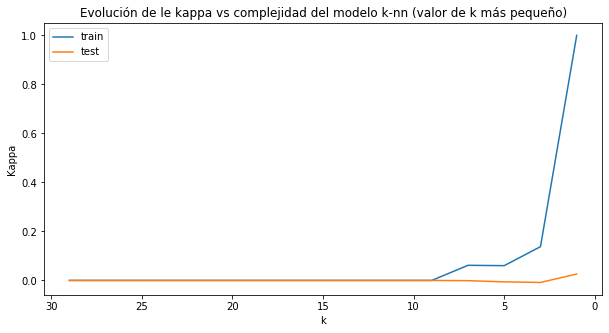

In [94]:
plt.figure(figsize=(10,5))
ax = plt.gca() # get current axis
plt.plot(k_vec, kappa_train_vec)
plt.plot(k_vec, kappa_test_vec)
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('k')
plt.ylabel('Kappa')
plt.title('Evolución de le kappa vs complejidad del modelo k-nn (valor de k más pequeño)')
plt.legend(['train', 'test'])

In [95]:
knn = neighbors.KNeighborsClassifier(n_neighbors=5)
Kappa=metrics.make_scorer(metrics.cohen_kappa_score)
kappas = cross_val_score(knn, x, y, cv=5, scoring=Kappa)
kappas

array([-0.00150483, -0.00150602,  0.        , -0.00617553,  0.        ])

In [96]:
knn = neighbors.KNeighborsClassifier(n_neighbors=1)
kf = KFold(n_splits=5, shuffle=True)
Kp=[]
for indices_train, indices_test in kf.split(x):
   #print("%s %s" % (indices_train, indices_test))
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    Kp.append(metrics.cohen_kappa_score(y_test, y_pred))  
Kp

[0.026080555263434557,
 0.026080555263434557,
 0.026080555263434557,
 0.026080555263434557,
 0.026080555263434557]

...

...

# 5. Naive Bayes

In [97]:
x=data[["Cuenta","Deuda"]]
y=data[["PudoPagar"]]

In [98]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=9876, stratify=y)

In [99]:
x["Deuda"]= x["Deuda"] / np.linalg.norm(x["Deuda"])
x["Cuenta"]= x["Cuenta"] / np.linalg.norm(x["Cuenta"])

In [100]:
x[0:5]

,Cuenta,Deuda
0,0.008893,0.014174
1,0.013087,0.010150
2,0.006452,0.011408
3,0.009577,0.012290
4,0.010063,0.007958


In [101]:
modelo = GaussianNB() #Alpha indica el coeficiente de Laplace smoothing de las probabilidades
modelo.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [102]:
Kappa=metrics.make_scorer(metrics.cohen_kappa_score)
exactitudes = cross_val_score(modelo, x, y, cv=5, scoring=Kappa)

In [103]:
y_pred = modelo.predict(X_test)

In [104]:
cm= metrics.confusion_matrix(y_test, y_pred)
cm

array([[2530,    0],
       [  35,    0]])

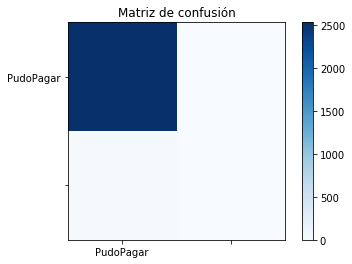

In [105]:
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Matriz de confusión")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, y)
plt.yticks(tick_marks, y)
plt.show()

In [106]:
print("Exactitud: ", metrics.accuracy_score(y_test, y_pred))
print("Kappa    : ", metrics.cohen_kappa_score(y_test, y_pred))
print("Precisión     : ", metrics.precision_score(y_test, y_pred))
print("Recall        : ", metrics.recall_score(y_test, y_pred))
VN = np.sum(cm[1:3,1:3])
FP = np.sum(cm[0,1:3])
specificity = VN/(VN+FP)
print("Especificidad : ", specificity)
print("F1-score      : ", metrics.f1_score(y_test, y_pred))
print("AUC           : ", metrics.roc_auc_score(y_test, y_pred))
print("-------------------------------------")

Exactitud:  0.98635477582846
Kappa    :  0.0
Precisión     :  0.0
Recall        :  0.0
Especificidad :  nan
F1-score      :  0.0
AUC           :  0.5
-------------------------------------


In [107]:
kappa_test_vec=[]
alpha_vec= []
for i in range(0, 101):
    alpha_vec.append(i/100)
    
for alpha in alpha_vec:
    modelo = MultinomialNB(alpha=alpha)
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    kappa_test_vec.append(metrics.cohen_kappa_score(y_test, y_pred))
print(kappa_test_vec)
print(alpha_vec)

[0.029330262499338677, 0.029330262499338677, 0.029330262499338677, 0.029330262499338677, 0.029330262499338677, 0.029330262499338677, 0.029330262499338677, 0.029330262499338677, 0.029330262499338677, 0.029330262499338677, 0.029330262499338677, 0.029330262499338677, 0.029330262499338677, 0.029330262499338677, 0.029330262499338677, 0.029330262499338677, 0.029330262499338677, 0.029330262499338677, 0.029330262499338677, 0.029330262499338677, 0.029330262499338677, 0.029330262499338677, 0.029330262499338677, 0.029330262499338677, 0.029330262499338677, 0.029330262499338677, 0.029330262499338677, 0.029330262499338677, 0.029330262499338677, 0.029330262499338677, 0.029330262499338677, 0.029330262499338677, 0.029330262499338677, 0.029330262499338677, 0.029330262499338677, 0.029330262499338677, 0.029330262499338677, 0.029330262499338677, 0.029330262499338677, 0.029330262499338677, 0.029330262499338677, 0.029330262499338677, 0.029330262499338677, 0.029330262499338677, 0.029330262499338677, 0.0293302

Text(0.5, 1.0, 'Evolución de le kappa vs var_smoothing ')

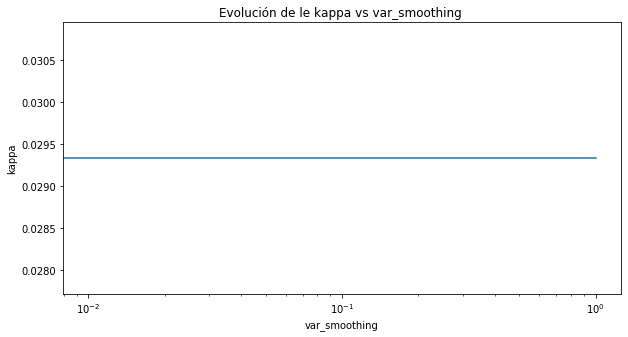

In [108]:
plt.figure(figsize=(10,5))
plt.plot(alpha_vec, kappa_test_vec)

ax = plt.gca() # get current axis
plt.xscale('log') # poner el aje del X en escala logaritmica

plt.xlabel('var_smoothing')
plt.ylabel('kappa')
plt.title('Evolución de le kappa vs var_smoothing ')

In [109]:
alpha_optimo = alpha_vec[np.argmax(kappa_test_vec)]
acc_optima= max(kappa_test_vec)
print("El óptimo se obtiene con alpha=%f, que produce un %3f%% de kappa" %(alpha_optimo, acc_optima))

El óptimo se obtiene con alpha=0.000000, que produce un 0.029330% de kappa


In [110]:
alphas = pd.DataFrame({"var_smoothing": alpha_vec, "kappa": kappa_test_vec})
alphas

,var_smoothing,kappa
0,0.00,0.02933
1,0.01,0.02933
2,0.02,0.02933
3,0.03,0.02933
4,0.04,0.02933
5,0.05,0.02933
6,0.06,0.02933
7,0.07,0.02933
8,0.08,0.02933
9,0.09,0.02933


In [111]:
modelo = MultinomialNB(alpha=0.1)
modelo.fit(X_train, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

# estudiante

In [112]:
data_est=data.loc[data['Estudiante'] == 1]

In [113]:
x=data_est[["Cuenta","Deuda"]]
y=data_est["PudoPagar"]

In [114]:

x["Deuda"]= x["Deuda"] / np.linalg.norm(x["Deuda"])
x["Cuenta"]= x["Cuenta"] / np.linalg.norm(x["Cuenta"])

In [115]:
modelo = GaussianNB() #Alpha indica el coeficiente de Laplace smoothing de las probabilidades
modelo.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [116]:
Kappa=metrics.make_scorer(metrics.cohen_kappa_score)
exactitudes = cross_val_score(modelo, x, y, cv=5, scoring=Kappa)

In [117]:
y_pred = modelo.predict(X_test)

In [118]:
cm= metrics.confusion_matrix(y_test, y_pred)
cm

array([[2530,    0],
       [  35,    0]])

...

...

# 6. Comparación y conclusiones

...

# Dado que KNN tiene un Kappa mayor, siendo este 0.09460616438356162 es pertinenente concluir que es un mejor modelo para estos datos.

...

...